<h1>Wasserstein-GAN (WGAN)</h1>
- Mit Gradient Penalty

Es gibt viele interessante Artikel, die das Thema näherbringen und erläutern.

>Ein sehr interessanter Artikel mit vielen Details zur Funktionsweise von WGAN <br>
> Enhancing Generative Modeling: A Comprehensive Analysis of Wasserstein GAN (WGAN): <br>
> https://medium.com/aimonks/enhancing-generative-modeling-a-comprehensive-analysis-of-wasserstein-gan-wgan-81b4c4a5f333 [Letzter Zugriff: 26.07.2024]

> Demystified: Wasserstein GAN with Gradient Penalty(WGAN-GP): <br> 
> https://towardsdatascience.com/demystified-wasserstein-gan-with-gradient-penalty-ba5e9b905ead [Letzter Zugriff: 26.07.2024]

> WGAN-gp (keras) <br>
> https://www.kaggle.com/code/amanooo/wgan-gp-keras [Letzter Zugriff: 26.07.2024]

> Ein sehr guter Artikel die viele wichtige Kernelemente von GAN, WGAN und WGAN-GP erläutert. <br>
> GAN — Wasserstein GAN & WGAN-GP:<br>
> https://jonathan-hui.medium.com/gan-wasserstein-gan-wgan-gp-6a1a2aa1b490 [Letzter Zugriff: 29.07.2024]

Was ist aber der Unterschied zwischen WGAN und GAN? <br>
Wasserstein-GAN hat einige Vorteile gegenüber der normalen Varianten von GAN. WGAN ist sinnvoll, wenn komplexere Datasets genutzt werden. WGAN bietet ein stabileres Training und eine bessere Abdeckung der Features. <br>
Der Output von einem WGAN hat eine höhere Diversität als von gewöhnliche GANs, also mehr Unterschiede in den generierten Bildern. <br>
Mit WGAN wird das Problem des Vanishing-Gradient angegangen durch den Einsatz von der Wasserstein-Distanz. Durch diese Distanz bekommen wir seichtere Gradienten und das Training läuft insgesamt stabiler.<br>

In dem Aufbau gibt es wieder viele Freiheiten. Je nach Dataset oder Aufgabe kann das Verfahren angepasst werden.

Die Variante WGAN-GP nutzt zusätzliche Gradient Penalty.:<br>
Bei der Basisvariante WGAN wird Weight-Clipping genutzt, dabei werden die Gradienten in einem festen Bereich gehalten. Statt Clipping nutzen wir eine Penalty <br>

<i>Abb1</i>: Schaubild der Wasserstein-GAN Gradient-Penalty Elemente.

<img src='./data/img/3_gan.PNG' width=600 height=700>

Credit: Bildquelle: <br>
> Ein WGAN-GP Beispiel. <br>
> WGAN-gp (keras): https://www.kaggle.com/code/amanooo/wgan-gp-keras#WGAN-gp-Model [Letzter Zugriff: 29.07.2024]

<h1>Aufgabe und Dataset</h1>

Die Aufgabe ist es mit einem GAN Netzwerk menschliche Gesichter zu generieren. Dabei soll die GAN Variante WGAN-GP genutzt werden. <br>
Ziel ist es die Anwendung mit WGAN-GP zu zeigen. 

In [1]:
# Imports.
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import PIL
import cv2

Das Dataset was wir nutzen ist CelebFaces, was viele verschiedene Gesichter von Menschen des öffentlichen Leben enthält.<br>
Das Dataset kann unter anderem dafür genutzt werden, um bestimmte Features wie eine Nase oder einen Mund zu erkennen. Hier Nutzen wir es, um ein Netz zu trainieren, das ähnliche Gesichter generieren soll.

Dataset:
> CelebFaces Attributes (CelebA) Dataset:  Over 200k images of celebrities with 40 binary attribute annotations <br>
> https://www.kaggle.com/datasets/jessicali9530/celeba-dataset  [Letzter Zugriff: 26.07.2024]

In [2]:
# Gebe URL des Speicherortes an und liste Bilder auf. 
url = "./data/datasets/faces/img_align_celeba/img_align_celeba"
image_names = os.listdir(url)
len(image_names)

202599

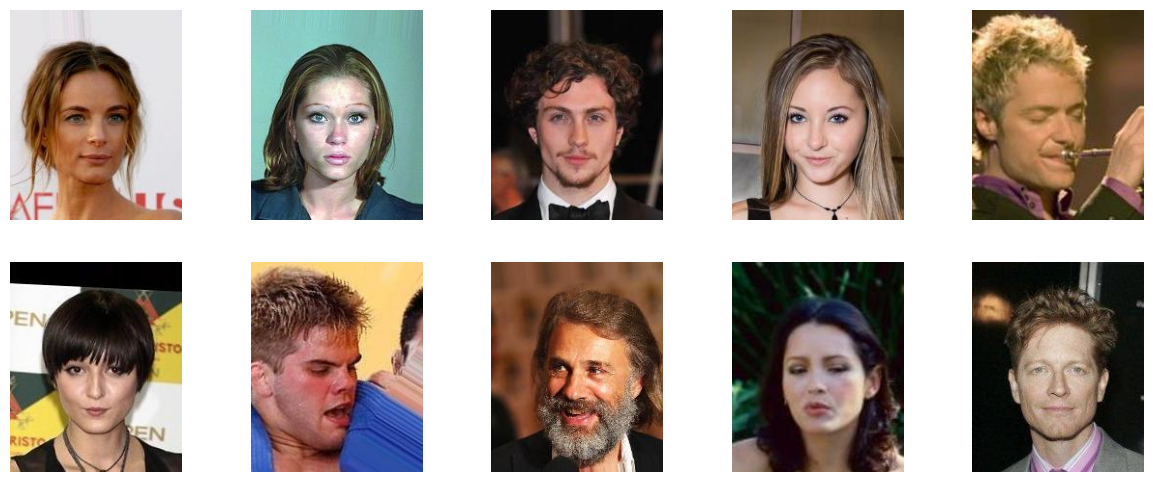

In [14]:
# Bilder können einfach mit Matplotlib gezeigt werden.

fig, axs = plt.subplots(2,5, figsize=(15, 6))
axs = axs.ravel()


for i, index in enumerate(np.random.randint(0, len(image_names)-1, 10)):  # Zufällige Bilder.
    img = PIL.Image.open(url+'/'+image_names[index])
    axs[i].set_axis_off()
    axs[i].imshow(img)

Man sieht wie Umfangreich das Dataset ist. Da wir hier nur eine CPU nutzen, wird das Dataset begrenzt. 

In [137]:
# Erstelle Dataset #

draw_n_samples = 12000
batch_size     = 16 

image_names = np.array(image_names)
# Schreibe Generator für Dataset. 
def load_img():
    for name in image_names[np.random.randint(0, len(image_names)-1, draw_n_samples)]:  # image_names enthählt alle Bilder. 
        img       = cv2.imread(url+'/'+name)  # Lade  Bild.
        resizeImg = cv2.resize(img, dsize=(64, 64))  # Ändere Größe.
        scaledImg =  (resizeImg - 127.5 ) / 127.5  # Skaliere.

        yield scaledImg

# Erstelle TensorFlow Dataset.
tf_face_dataset = tf.data.Dataset.from_generator(load_img, output_shapes=(64, 64, 3), output_types=(tf.float32), 
                                                ).batch(batch_size, drop_remainder=True).cache().prefetch(buffer_size=1024)
tf_face_dataset

<PrefetchDataset element_spec=TensorSpec(shape=(16, 64, 64, 3), dtype=tf.float32, name=None)>

Optional können weitere Transformationen angewendet werden. 

<h2>Erstelle Model</h2>

Jetzt erstellen wir einen Generator und einen Discriminator. In dem Kontext von WGAN bezeichnet man den Discriminator als <u>Critic</u>

Dafür erstellen wir eine Klasse, um viele Operationen unter einem Hut zu kriegen. Zudem kann die Klasse als Template genutzt werden. 

In [138]:
# Erstelle Klasse für GAN.:
# - WGAN-GP für 1 Bildklasse. 
# - Klasse kann erweitert werden. 
class GAN_Network():
    
    def __init__(self, generator:tf.keras.Model, critic:tf.keras.Model, 
                 GenOpt:tf.optimizers,  CriticOpt:tf.optimizers):
        self.generator = generator
        self.critic    = critic
        self.GenOpt    = GenOpt
        self.CriticOpt = CriticOpt
        print(f"Generator:\n" + \
              f" Input: {self.generator.input_shape}\n Output: {self.generator.output_shape}, Opt: {self.GenOpt}")
        print(f"Critic:\n"+ \
             f" Input: {self.critic.input_shape}\n Output: {self.critic.output_shape}, Opt: {self.CriticOpt}")

    def set_generator(self, generator:tf.keras.Model, GenOpt:tf.optimizers):
        del self.generator
        self.generator = generator
        print(f"Generator:\n" + \
              f"Input: {self.generator.input_shape}\n Output: {self.generator.output_shape}")
        
    def set_critic(self, critic:tf.keras.Model, CriticOpt:tf.optimizers):
        del self.critic
        self.critic = critic
        print(f"Generator:\n" + \
              f"Input: {self.critic.input_shape}\n Output: {self.critic.output_shape}")

    def get_generator(self):
        return self.generator

    def get_critic(self):
        return self.critic

    def load_GeneratorWeights_from_file(self,path:str):
        try:
            self.generator.load_weights(self,path)
        except FileNotFoundError:
            print(FileNotFoundError)

    def load_CriticWeights_from_file(self,path:str):
        try:
            self.critic.load_weights(path)
        except FileNotFoundError:
            print(FileNotFoundError)

    def save_Generator_weights(self,path:str):
        model.save_weights(path)

    def save_Critic_weights(path:str):
        model.save_weights(path)

    def predict_image(self,) -> np.array:
        # Für Batch: mehfaches aufrufen. 
        noise_dim = self.generator.input_shape[1]
        noise = np.random.normal(0, 1, (1, noise_dim))
        return np.array(self.generator.predict(noise))

    # --- # Training und Zusätze

    def __generator_loss(self,fake_output):
        return -tf.reduce_mean(fake_output)

    def __critic_loss(self,real_output, fake_output):
        return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

    # Kernelement: Gradient Penalty # 
    # - GGf. Casts von Datentypen. 
    def __gradient_penalty(self, real_images, fake_images, batch_size):
        real_images = tf.cast(real_images, tf.double)  # Cast
        fake_images = tf.cast(fake_images, tf.double)  # Cast 

        # Damit erstellen wir ein Avarage Image das dem Discriminator übergeben wird.
        # - Siehe Abb1 oben.
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)  # 
        alpha = tf.cast(alpha, tf.double)
    
        interpolated = real_images * alpha + fake_images * (1 - alpha)
        interpolated = tf.cast(interpolated, tf.double)
    
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)
        grads = tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))  # Summiere Gradienten und beachte dabei die Farbchannels 
        # Gradient Penalty # 
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    
    def fit(self, dataset:tf.data.Dataset, batch_size:int, epochs:int ):
        print(f"--Start Training--\nBatch: {batch_size} | Epoches: {epochs}\n")
        
        noise_dim = self.generator.input_shape[1]
        gen_loss_list    = []
        critic_loss_list = []
        # Weitere Listen...
        for epoch in range(epochs):
            gan_batch_loss = []
            critic_batch_loss = []
            # gradient_panelty optional, weitere Aufzeichnungen...  

            for real_images in dataset:
                
                lambda_gp=10
                # Nutze ggf. Casting. 
                real_images = tf.cast(real_images, tf.double)
                noise = tf.random.normal([batch_size, noise_dim])
                noise = tf.cast(noise, tf.double)
                
                with tf.GradientTape() as gen_tape, tf.GradientTape() as crit_tape:
                    fake_images = self.generator(noise, training=True)
                    #fake_images = tf.cast(fake_images, tf.double)
        
                    real_output = self.critic(real_images, training=True)
                    fake_output = self.critic(fake_images, training=True)
        
                    gen_loss  = self.__generator_loss(fake_output)
                    crit_loss = self.__critic_loss(real_output, fake_output)
                    gp = self.__gradient_penalty(real_images, fake_images, batch_size)

                    lambda_gp = tf.cast(lambda_gp, tf.float32)
                    gp = tf.cast(gp, tf.float32)
                    # Kernelement von WGAN-GP
                    crit_loss +=  gp * lambda_gp 
                gan_batch_loss.append(gen_loss)
                critic_batch_loss.append(crit_loss)

                # Wende Gradienten an.
                gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
                gradients_of_critic    = crit_tape.gradient(crit_loss, self.critic.trainable_variables)
    
                self.GenOpt.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
                self.CriticOpt.apply_gradients(zip(gradients_of_critic, self.critic.trainable_variables))
                
                # Optionale Ausgaben 
            
            gen_loss_list.append(np.array(gan_batch_loss).mean())
            critic_loss_list.append(np.array(critic_batch_loss).mean())
    
            # Optionale Ausgaben pro Epoche. 
            print(f'Epoche: {epoch+1}/{epochs} G_Loss: {np.array(gan_batch_loss).mean()}, C_Loss: {np.array(critic_batch_loss).mean()}')
        


In [139]:
# Erstelle Generator CNN # 
# - Füge weitere Layers hinzu... 
def get_generator(img_dim:int=100):
    model = tf.keras.Sequential()
    # ---- # Skaliere Noise Vektor 
    model.add(tf.keras.layers.Dense(units=8*8*256, input_shape=(img_dim, ), use_bias=False))  
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Reshape(( 8, 8, 256)))   # TensorShape([1, 8, 8, 256])
    # ------------ #
    # Transpose # 1
    # filters: Anzahl Filter, um Features zu erkennen. kernel_size: Größe Filter. padding: Art des Paddings, siehe Dok. 
    # Strides: Schrittweite des Filters.
    model.add(tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(5,5),  padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())  # TensorShape([1, 8, 8, 256])
    # Transpose # 2
    model.add(tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())  # TensorShape([1, 16, 16, 64])
    # Transpose # 3
    model.add(tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False))  
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())  # TensorShape([1, 32, 32, 32])

    model.add(tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))  # TensorShape([1, 64, 64, 3])

    return model

In [141]:
# Erstelle Critic CNN #
def get_discriminator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=( 64, 64, 3)))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model

<h2>Training</h2>

In [142]:
# Erstelle Modelle.
generator = get_generator()
critic = get_discriminator()

In [143]:
GAN_op = GAN_Network( 
    generator,
    critic, 
    tf.keras.optimizers.RMSprop(),
    tf.keras.optimizers.RMSprop()   
)
# Modelle können einfach ausgetauscht werden werden. 

Generator:
 Input: (None, 100)
 Output: (None, 64, 64, 3), Opt: <keras.optimizers.optimizer_v2.rmsprop.RMSprop object at 0x00000196841B0460>
Critic:
 Input: (None, 64, 64, 3)
 Output: (None, 1), Opt: <keras.optimizers.optimizer_v2.rmsprop.RMSprop object at 0x0000019686D886D0>


In [144]:
GAN_op.fit(tf_face_dataset, batch_size, 30)

--Start Training--
Batch: 16 | Epoches: 30

Epoche: 1/30 G_Loss: 1.0920664072036743, C_Loss: -1.9956696033477783
Epoche: 2/30 G_Loss: 4.625229835510254, C_Loss: -1.3594028949737549
Epoche: 3/30 G_Loss: 3.7925493717193604, C_Loss: -1.2028709650039673
Epoche: 4/30 G_Loss: 5.460550785064697, C_Loss: -1.4131256341934204
Epoche: 5/30 G_Loss: 32.89541244506836, C_Loss: -0.433974027633667
Epoche: 6/30 G_Loss: 9.829621315002441, C_Loss: -0.49772101640701294
Epoche: 7/30 G_Loss: 0.536653995513916, C_Loss: -0.2589152157306671
Epoche: 8/30 G_Loss: 0.43011051416397095, C_Loss: -0.41497305035591125
Epoche: 9/30 G_Loss: 19.314498901367188, C_Loss: -0.33938542008399963
Epoche: 10/30 G_Loss: -13.55733585357666, C_Loss: -0.2653864622116089
Epoche: 11/30 G_Loss: -6.769662857055664, C_Loss: -0.7730280160903931
Epoche: 12/30 G_Loss: 7.698577404022217, C_Loss: 0.11621400713920593
Epoche: 13/30 G_Loss: -21.432979583740234, C_Loss: -0.3676312267780304
Epoche: 14/30 G_Loss: 46.011474609375, C_Loss: -0.1805211

<h2>Predict und Sonstiges</h2>

1/1 [==============================] - 0s 26ms/step


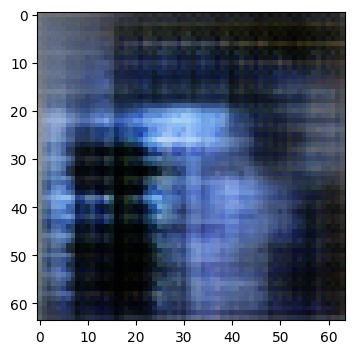

In [156]:
noise = np.random.normal(0, 1, (1, 100))
fake = generator.predict(noise)
plt.figure(figsize=(4,4))
fake  = (fake * 127.5 + 127.5).astype(np.uint8)
plt.imshow(fake[0])

In [ ]:
# Evaluate the Results: Assess the quality of the images generated by the generator. Use metrics suitable for GANs, like Inception Score (IS) or Frechet Inception Distance (FID), if applicable.